# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import glob
from scipy import stats
from math import radians, cos, sin, asin, sqrt

# Import csv files

In [2]:
# Removed files with 0mb and also 2019. We want to know 2020-10 tm 2020-12 for now.
files = glob.glob(r'GVB/*.csv')
gvb_data = pd.concat( (pd.read_csv(file, sep=";") for file in files), ignore_index = True)
gvb_data.head()

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
0,10/31/2020 12:00:00 AM,18:00 - 18:59,NaN,Overig,NaN,NaN,1
1,11/30/2020 12:00:00 AM,00:00 - 00:59,NaN,Overig,NaN,NaN,4
2,11/30/2020 12:00:00 AM,01:00 - 01:59,NaN,Overig,NaN,NaN,53
3,11/30/2020 12:00:00 AM,02:00 - 02:59,NaN,Overig,NaN,NaN,49
4,11/30/2020 12:00:00 AM,03:00 - 03:59,NaN,Overig,NaN,NaN,30


In [3]:
# Read Resono data for later
resono = pd.read_csv("resono_2020_2022.csv")
resono.head()

,Unnamed: 0,Location,End,Visits,End_Dates,End_Time
0,0,Amstelpark,2020-11-12 00:15:00,15,2020-11-12,00:15:00
1,1,Amstelpark,2020-11-12 00:30:00,15,2020-11-12,00:30:00
2,2,Amstelpark,2020-11-12 00:45:00,11,2020-11-12,00:45:00
3,3,Amstelpark,2020-11-12 01:00:00,8,2020-11-12,01:00:00
4,4,Amstelpark,2020-11-12 01:15:00,3,2020-11-12,01:15:00


# Preprocess GVB data

In [4]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def add_nearby_stations(radius, center_point_dict, add_to_list):
    """
    radius in km
    center_point_dict needs to be a dictionary with the lon and lat from a location
    add_to_list specify to which list this needs to be added (for example vondelpark)
    """
    latpark = center_point_dict[0]['lat']
    lonpark = center_point_dict[0]['lng']

    # check for every station if it is within 1 km distance of the park
    for station in range(len(stations_lon_lat)):
        name_station = stations_lon_lat.iloc[station].name
        latstation = stations_lon_lat.iloc[station].lat
        lonstation = stations_lon_lat.iloc[station].lng

        a = haversine(lonpark, latpark, lonstation, latstation)
        
        if a <= radius:
            add_to_list.append(name_station)
            
def pre_process_GVB(gvb_data):
    # Set dates to datetime
    # Only select data from 10-2020 till 12-2021
    # Drop if destination is unknown
    # Remove NaN and [[ Onbekend ]] values
    gvb_data['Datum'] = pd.to_datetime(gvb_data['Datum'])
    gvb_data = gvb_data.sort_values(by=['Datum', 'UurgroepOmschrijving (van aankomst)'])
    gvb_data_range = gvb_data[(gvb_data['Datum'] >= '2020-10-1') & (gvb_data['Datum'] <= '2021-12-31')]
    gvb_data_range_cleaned = gvb_data_range[gvb_data_range['AankomstHalteCode'].notnull()]
    gvb_data_range_cleaned = gvb_data_range_cleaned[gvb_data_range_cleaned['AankomstHalteNaam'] != "[[ Onbekend ]]"]

    # Replace missing data with one week before
    gvb_data_range_cleaned_without_9_november = gvb_data_range_cleaned[gvb_data_range_cleaned['Datum'] != "2020-11-09"]
    gvb_week46 = gvb_data_range_cleaned[(gvb_data_range_cleaned['Datum'] >= '2020-11-02') & (gvb_data_range_cleaned['Datum'] <= '2020-11-08')]
    gvb_week46['Datum'] = gvb_week46["Datum"] + dt.timedelta(days=7)
    frames = [gvb_data_range_cleaned_without_9_november, gvb_week46]
    gvb_data_range_very_cleaned = pd.concat(frames)
    gvb_data_range_very_cleaned.sort_values(by="Datum", inplace=True)
    
    # Still a lot of values are missing, make sure every data point gets added and interpolated
    # take last hour from column UurgroepOmschrijving and convert to datetime
    # add one minute to get hour, so 17:00 means 16:00 - 16:59
    # cmobine date and hour to make index unique
    gvb_data_range_travels = gvb_data_range_very_cleaned.copy()

    gvb_data_range_travels['hour'] = gvb_data_range_travels['UurgroepOmschrijving (van aankomst)'].str[:5]
    gvb_data_range_travels['hour'] = pd.to_datetime(gvb_data_range_travels['hour'], format='%H:%M').dt.time
    gvb_data_range_travels['date'] = gvb_data_range_travels.apply(lambda r : pd.datetime.combine(r['Datum'],r['hour']),1)
    gvb_data_range_travels = gvb_data_range_travels.drop(columns=['Datum', 'UurgroepOmschrijving (van aankomst)',
                                                                  'AankomstHalteCode','hour'])
    
    # Create DF with all stations with their lon and lat
    stations_lon_lat = gvb_data_range_travels.drop_duplicates(subset=['AankomstHalteNaam'])[['AankomstHalteNaam', 'AankomstLon', 'AankomstLat']]
    stations_lon_lat = stations_lon_lat.set_index('AankomstHalteNaam')
    stations_lon_lat.rename(columns={"AankomstLat": "lng", "AankomstLon": "lat"}, inplace=True)  
    
    gvb_data_range_travels = gvb_data_range_travels.drop(columns=['AankomstLat', 'AankomstLon'])    
    
    return gvb_data_range_travels, stations_lon_lat

    

In [5]:
cleaned_gvb, stations_lon_lat = pre_process_GVB(gvb_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [8]:
# Center points of all the parks (https://www.latlong.net/)
all_parks = ['vondelpark_west','vondelpark_oost_3','vondelpark_oost_2',
             'vondelpark_oost_1' 'oosterpark', 'sarphatipark',
            'westerpark_west','westerpark_oost','westerpark_centrum', 
             'westergasfabriek','rembrandtpark_noord', 'rembrandtpark_zuid', 
             'erasmuspark']

vondelpark_west = [{'lat': 52.356496, 'lng': 4.861447}]
vondelpark_oost_3 = [{'lng': 4.869217, 'lat': 52.358252}]
vondelpark_oost_2 = [{'lng': 4.874692, 'lat': 52.359798}]
vondelpark_oost_1 = [{'lng': 4.879652, 'lat': 52.360991}]
oosterpark = [{'lng': 4.920558, 'lat': 52.360098}]
sarphatipark = [{'lng': 4.896375, 'lat': 52.354364}]
westerpark_west = [{'lng': 4.867128, 'lat': 52.387099}]
westerpark_centrum = [{'lng': 4.873268, 'lat': 52.387374}]
westerpark_oost = [{'lng': 4.878379, 'lat': 52.386379}]
westergasfabriek = [{'lng': 4.869769, 'lat': 52.385920}]
rembrandtpark_noord = [{'lng': 4.846573, 'lat': 52.366664}]
rembrandtpark_zuid = [{'lng': 4.846932, 'lat': 52.361161}]
erasmuspark = [{'lng': 4.851909, 'lat': 52.374808}]
amstelpark = [{'lng': 4.894404, 'lat': 52.330409}]
park_frankendael = [{'lng': 4.929839, 'lat': 52.350703}]
beatrixpark = [{'lng': 4.881352, 'lat': 52.342471}]
flevopark = [{'lng': 4.947881, 'lat': 52.360087}]
gaasperpark = [{'lng': 4.992192, 'lat': 52.310420}]
nelson_mandelapark = [{'lng': 4.963691, 'lat': 52.312204}]
noorderpark = [{'lng': 4.919606, 'lat': 52.392651}]
sloterpark = [{'lng': 4.811894, 'lat': 52.366219}]
wh_vliegenbos = [{'lng': 4.931495, 'lat': 52.388802}]

# Create empty list that needs to be filled later
vondelpark_west_stations = []
vondelpark_oost_3_stations = []
vondelpark_oost_2_stations = []
vondelpark_oost_1_stations = []
oosterpark_stations = []
sarphatipark_stations = []
westerpark_west_stations = []
westerpark_centrum_stations = []
westerpark_oost_stations = []
westergasfabriek_stations = []
rembrandtpark_noord_stations = []
rembrandtpark_zuid_stations = []
erasmuspark_stations = []

amstelpark_stations = []
park_frankendael_stations= []
beatrixpark_stations = []
flevopark_stations = []
gaasperpark_stations = []
nelson_mandelapark_stations = []
noorderpark_stations = []
sloterpark_stations = []
wh_vliegenbos_stations = []

# calculate all stations within 1 km from the park
add_nearby_stations(1,vondelpark_west, vondelpark_west_stations)
add_nearby_stations(1,vondelpark_oost_3, vondelpark_oost_3_stations)
add_nearby_stations(1,vondelpark_oost_2, vondelpark_oost_2_stations)
add_nearby_stations(1,vondelpark_oost_1, vondelpark_oost_1_stations)
add_nearby_stations(1,oosterpark,oosterpark_stations)
add_nearby_stations(1,sarphatipark,sarphatipark_stations)
add_nearby_stations(1,westergasfabriek, westergasfabriek_stations)
add_nearby_stations(1,westerpark_west, westerpark_west_stations)
add_nearby_stations(1,westerpark_centrum, westerpark_centrum_stations)
add_nearby_stations(1,westerpark_oost, westerpark_oost_stations)
add_nearby_stations(1,rembrandtpark_noord,rembrandtpark_noord_stations)
add_nearby_stations(1,rembrandtpark_zuid,rembrandtpark_zuid_stations)
add_nearby_stations(1,erasmuspark,erasmuspark_stations)

add_nearby_stations(1,amstelpark,amstelpark_stations)
add_nearby_stations(1,park_frankendael,park_frankendael_stations)
add_nearby_stations(1,beatrixpark,beatrixpark_stations)
add_nearby_stations(1,flevopark,flevopark_stations)
add_nearby_stations(1,gaasperpark,gaasperpark_stations)
add_nearby_stations(1,nelson_mandelapark,nelson_mandelapark_stations)
add_nearby_stations(1,noorderpark,noorderpark_stations)
add_nearby_stations(1,sloterpark,sloterpark_stations)
add_nearby_stations(1,wh_vliegenbos,wh_vliegenbos_stations)

# from here the new parks still need to be processed

In [25]:
vondelpark_west_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(vondelpark_west_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
vondelpark_oost1_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(vondelpark_oost_1_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
vondelpark_oost2_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(vondelpark_oost_2_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
vondelpark_oost3_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(vondelpark_oost_3_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
oosterpark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(oosterpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
sarphatipark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(sarphatipark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_west_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(westerpark_west_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_centrum_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(westerpark_centrum_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_oost_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(westerpark_oost_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westergasfabriek_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(westergasfabriek_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
rembrandtpark_noord_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(rembrandtpark_noord_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
rembrandtpark_zuid_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(rembrandtpark_zuid_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
erasmuspark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(erasmuspark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()

amstelpark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(amstelpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
park_frankendael_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(park_frankendael_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
beatrixpark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(beatrixpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
flevopark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(flevopark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
gaasperpark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(gaasperpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
nelson_mandelapark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(nelson_mandelapark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
noorderpark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(noorderpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
sloterpark_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(sloterpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
wh_vliegenbos_journeys = cleaned_gvb[cleaned_gvb['AankomstHalteNaam'].isin(wh_vliegenbos_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()

# concatenate all dataframes into one, for later usage
vondelpark_west_journeys["park"] = 'vondelpark_west'
vondelpark_oost1_journeys["park"] = 'vondelpark_oost_1'
vondelpark_oost2_journeys["park"] = 'vondelpark_oost_2'
vondelpark_oost3_journeys["park"] = 'vondelpark_oost_3'
oosterpark_journeys["park"] = "oosterpark"
sarphatipark_journeys["park"] = "sarphatipark"
westerpark_west_journeys["park"] = "westerpark_west"
westerpark_oost_journeys["park"] = "westerpark_oost"
westerpark_centrum_journeys["park"] = "westerpark_centrum"
westergasfabriek_journeys["park"] = "westergasfabriek"
rembrandtpark_noord_journeys["park"] = "rembrandtpark_noord"
rembrandtpark_zuid_journeys["park"] = "rembrandtpark_zuid"
erasmuspark_journeys["park"] = "erasmuspark"

amstelpark_journeys["park"] = "amstelpark"
park_frankendael_journeys["park"] = "park_frankendael"
beatrixpark_journeys["park"] = "beatrixpark"
flevopark_journeys["park"] = "flevopark"
gaasperpark_journeys["park"] = "gaasperpark"
nelson_mandelapark_journeys["park"] = "nelson_mandelapark"
noorderpark_journeys["park"] = "noorderpark"
sloterpark_journeys["park"] = "sloterpark"
wh_vliegenbos_journeys["park"] = "wh_vliegenbos"

frames = [vondelpark_west_journeys, vondelpark_oost1_journeys, vondelpark_oost2_journeys, 
          vondelpark_oost3_journeys,oosterpark_journeys, sarphatipark_journeys, westerpark_west_journeys,
         westerpark_centrum_journeys, westerpark_oost_journeys, westergasfabriek_journeys,
         rembrandtpark_noord_journeys, rembrandtpark_zuid_journeys, erasmuspark_journeys,
         amstelpark_journeys, park_frankendael_journeys, beatrixpark_journeys, flevopark_journeys,
         gaasperpark_journeys, nelson_mandelapark_journeys, noorderpark_journeys, sloterpark_journeys, wh_vliegenbos_journeys]

all_parks_journeys = pd.concat(frames)


In [31]:
# Make all GVB data 15 min
vondelpark_west_journeys_15min = vondelpark_west_journeys.resample('15T').pad()
vondelpark_west_journeys_15min['AantalReizen'] = vondelpark_west_journeys_15min['AantalReizen'] / 4

vondelpark_oost1_journeys_15min = vondelpark_oost1_journeys.resample('15T').pad()
vondelpark_oost1_journeys_15min['AantalReizen'] = vondelpark_oost1_journeys_15min['AantalReizen'] / 4

vondelpark_oost2_journeys_15min = vondelpark_oost2_journeys.resample('15T').pad()
vondelpark_oost2_journeys_15min['AantalReizen'] = vondelpark_oost2_journeys_15min['AantalReizen'] / 4

vondelpark_oost3_journeys_15min = vondelpark_oost3_journeys.resample('15T').pad()
vondelpark_oost3_journeys_15min['AantalReizen'] = vondelpark_oost3_journeys_15min['AantalReizen'] / 4

oosterpark_journeys_15min = oosterpark_journeys.resample('15T').pad()
oosterpark_journeys_15min['AantalReizen'] = oosterpark_journeys_15min['AantalReizen'] / 4

sarphatipark_journeys_15min = sarphatipark_journeys.resample('15T').pad()
sarphatipark_journeys_15min['AantalReizen'] = sarphatipark_journeys_15min['AantalReizen'] / 4

rembrandtpark_noord_journeys_15min = rembrandtpark_noord_journeys.resample('15T').pad()
rembrandtpark_noord_journeys_15min['AantalReizen'] = rembrandtpark_noord_journeys_15min['AantalReizen'] / 4

rembrandtpark_zuid_journeys_15min = rembrandtpark_zuid_journeys.resample('15T').pad()
rembrandtpark_zuid_journeys_15min['AantalReizen'] = rembrandtpark_zuid_journeys_15min['AantalReizen'] / 4

westerpark_centrum_journeys_15min = westerpark_centrum_journeys.resample('15T').pad()
westerpark_centrum_journeys_15min['AantalReizen'] = westerpark_centrum_journeys_15min['AantalReizen'] / 4

westerpark_oost_journeys_15min = westerpark_oost_journeys.resample('15T').pad()
westerpark_oost_journeys_15min['AantalReizen'] = westerpark_oost_journeys_15min['AantalReizen'] / 4

westerpark_west_journeys_15min = westerpark_west_journeys.resample('15T').pad()
westerpark_west_journeys_15min['AantalReizen'] = westerpark_west_journeys_15min['AantalReizen'] / 4

westergasfabriek_journeys_15min = westergasfabriek_journeys.resample('15T').pad()
westergasfabriek_journeys_15min['AantalReizen'] = westergasfabriek_journeys_15min['AantalReizen'] / 4

erasmuspark_journeys_15min = erasmuspark_journeys.resample('15T').pad()
erasmuspark_journeys_15min['AantalReizen'] = erasmuspark_journeys_15min['AantalReizen'] / 4

amstelpark_journeys_15min= amstelpark_journeys.resample('15T').pad()
amstelpark_journeys_15min['AantalReizen'] = amstelpark_journeys_15min['AantalReizen'] / 4

park_frankendael_journeys_15min = park_frankendael_journeys.resample('15T').pad()
park_frankendael_journeys_15min['AantalReizen'] = park_frankendael_journeys_15min['AantalReizen'] / 4

beatrixpark_journeys_15min = beatrixpark_journeys.resample('15T').pad()
beatrixpark_journeys_15min['AantalReizen'] = beatrixpark_journeys_15min['AantalReizen'] / 4

flevopark_journeys_15min = flevopark_journeys.resample('15T').pad()
flevopark_journeys_15min['AantalReizen'] = flevopark_journeys_15min['AantalReizen'] / 4

gaasperpark_journeys_15min = gaasperpark_journeys.resample('15T').pad()
gaasperpark_journeys_15min['AantalReizen'] = gaasperpark_journeys_15min['AantalReizen'] / 4

nelson_mandelapark_journeys_15min = nelson_mandelapark_journeys.resample('15T').pad()
nelson_mandelapark_journeys_15min['AantalReizen'] = nelson_mandelapark_journeys_15min['AantalReizen'] / 4

noorderpark_journeys_15min = noorderpark_journeys.resample('15T').pad()
noorderpark_journeys_15min['AantalReizen'] = noorderpark_journeys_15min['AantalReizen'] / 4

sloterpark_journeys_15min = sloterpark_journeys.resample('15T').pad()
sloterpark_journeys_15min['AantalReizen'] = sloterpark_journeys_15min['AantalReizen'] / 4

In [32]:
# create list of unique locations and empty list with potential resono x park lists
locations = resono["Location"].unique().tolist()
resono_park_list_15min = []

for location in locations:   
    # create dynamic name (https://www.delftstack.com/howto/python/python-dynamic-variable-name/)
    name = f"min15_resono_{location.lower()}"
    name = "_".join(name.split())
    resono_park_list_15min.append(name)
    
    # prepare resono data
    resono_park = resono[resono['Location'] == location]
    resono_park = resono_park.set_index('End')
    resono_park.index = pd.to_datetime(resono_park.index, utc=True)
    resono_park.index = resono_park.index.tz_convert(None)
    resono_park.index = resono_park.index.tz_localize('utc') 
    
    parknaam = "_".join(location.lower().split())
    
    # prepare gvb data of certain park 
    gvb_park = all_parks_journeys[all_parks_journeys["park"] == parknaam]
    gvb_park.index = gvb_park.index.tz_localize('utc')

    # merge gvb and resono to new dynamic df
    globals()[name] = resono_park.loc["2020-10":].join(gvb_park) 
    globals()[name].index = globals()[name].index.tz_convert(None)

frames = [min15_resono_amstelpark, min15_resono_beatrixpark, min15_resono_erasmuspark,
         min15_resono_flevopark, min15_resono_gaasperpark, min15_resono_nelson_mandelapark,
         min15_resono_noorderpark, min15_resono_oosterpark, min15_resono_park_frankendael,
         min15_resono_rembrandtpark_noord, min15_resono_rembrandtpark_zuid, 
         min15_resono_sarphatipark, min15_resono_vondelpark_oost, min15_resono_vondelpark_oost_1,
         min15_resono_vondelpark_oost_2, min15_resono_vondelpark_oost_3, min15_resono_vondelpark_west,
         min15_resono_westergasfabriek, min15_resono_westerpark, min15_resono_westerpark_centrum,
         min15_resono_westerpark_oost, min15_resono_westerpark_west]
min15_all_resono_park = pd.concat(frames)

In [33]:
resono_park_list_15min

['min15_resono_amstelpark',
 'min15_resono_beatrixpark',
 'min15_resono_erasmuspark',
 'min15_resono_flevopark',
 'min15_resono_gaasperpark',
 'min15_resono_nelson_mandelapark',
 'min15_resono_noorderpark',
 'min15_resono_oosterpark',
 'min15_resono_park_frankendael',
 'min15_resono_rembrandtpark_noord',
 'min15_resono_rembrandtpark_zuid',
 'min15_resono_sarphatipark',
 'min15_resono_sloterpark',
 'min15_resono_vondelpark_oost',
 'min15_resono_vondelpark_oost_1',
 'min15_resono_vondelpark_oost_2',
 'min15_resono_vondelpark_oost_3',
 'min15_resono_vondelpark_west',
 'min15_resono_w.h._vliegenbos',
 'min15_resono_westergasfabriek',
 'min15_resono_westerpark',
 'min15_resono_westerpark_centrum',
 'min15_resono_westerpark_oost',
 'min15_resono_westerpark_west']

In [34]:
# Data transformations
min15_all_resono_park['Journeys_normal'] = min15_all_resono_park['AantalReizen'].backfill()
min15_all_resono_park.drop(columns=['AantalReizen', 'park']).dropna()

,Unnamed: 0,Location,Visits,End_Dates,End_Time,Journeys_normal
End,,,,,,
2020-11-12 00:15:00,0,Amstelpark,15,2020-11-12,00:15:00,59.0
2020-11-12 00:30:00,1,Amstelpark,15,2020-11-12,00:30:00,59.0
2020-11-12 00:45:00,2,Amstelpark,11,2020-11-12,00:45:00,59.0
2020-11-12 01:00:00,3,Amstelpark,8,2020-11-12,01:00:00,59.0
2020-11-12 01:15:00,4,Amstelpark,3,2020-11-12,01:15:00,59.0
...,...,...,...,...,...,...
2021-12-19 22:00:00,732921,Westerpark West,9,2021-12-19,22:00:00,32.0
2021-12-19 22:15:00,732922,Westerpark West,8,2021-12-19,22:15:00,10.0
2021-12-19 22:30:00,732923,Westerpark West,9,2021-12-19,22:30:00,10.0


In [ ]:
min15_all_resono_park.to_csv("gvb_resono.csv")

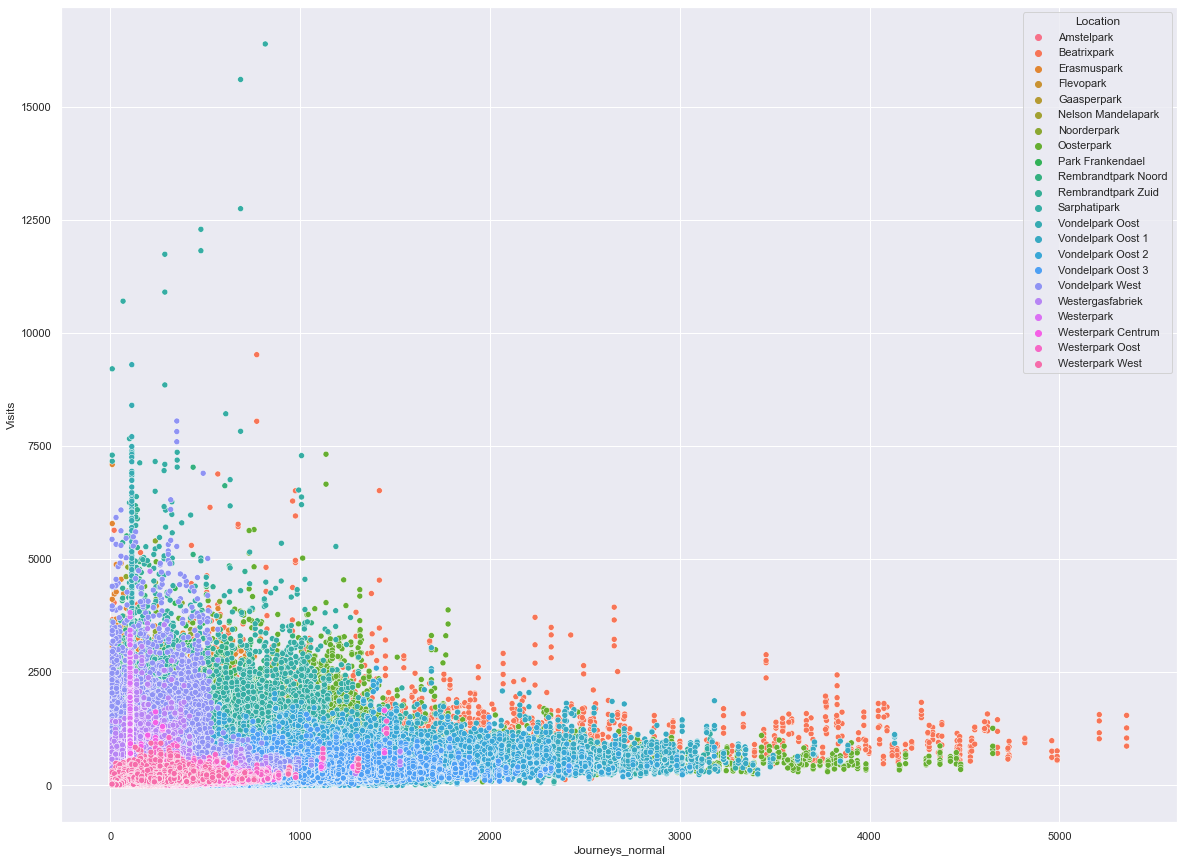

In [36]:
sns.set(rc={'figure.figsize':(20,15)})
sns.scatterplot(data=min15_all_resono_park, x="Journeys_normal", y="Visits", hue="Location");